In [36]:
import logging
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import logging
import jax
from math import log, exp, sqrt

from bmws import Observation, sim_and_fit, sim_wf
from bmws.betamix import forward, BetaMixture
from bmws.data import Dataset
from bmws.estimate import empirical_bayes, estimate, jittable_estimate, _beta_pdf
from bmws.sim import sim_admix
rng = np.random.default_rng()

# New data format

Create a list of "records" and then call `data = Dataset.from_records()`. Each record is of the form:

    rec = {
        't': t,  # time of observation (gens before present)
        'theta': theta  # [K] admixture proportions,
        'obs': (n, d)   # tuple: n = # of observed alleles, d = # of derived alleles.
    }
    
(For diploid data, $n=2$, while for pseuodhaploid data $n=1$)

## New objective function
Additional regularization terms have been added. The estimand $\mathbf{s}\in\mathbb{R}^{T\times K}$ is now a matrix with $T$ rows (time points) and $K$ columns/populations. The new objective function is:

$$f(\mathbf{s}) = -\mathrm{loglik}(\text{data}\mid N_e,\mathbf{s}) 
+ \alpha \sum_k \sum_{t=2}^T (s_{k,t} - s_{k,t-1})^2 
+ \beta \sum_t \sum_{k_1,k_2 \in [K]} (s_{k_1,t} - s_{k_2,t})^2 
+ \gamma \Vert \mathbf{s} \Vert_*$$

so:

- $\alpha$ controls smoothness "across time" of the $s_{kt}$ for each population $k$
- $\beta$ controls smoothness "between groups"
- $\gamma$ penalizes the rank of the matrix $s$, setting $\gamma\to\infty$ makes each estimated $s$ become a scalar multiple of the other.

$\beta$ and $\gamma$ sort of aim at the same goal, we'll need to experiment to see which makes more sense.

In [2]:

#Load data
def read_data(pop):

    admixture_proportions=pd.read_csv("data/"+pop+"_sample_info.txt", sep="\t")
    admixture_proportions["generation"]=[int(x) for x in round(admixture_proportions["Date"]/30)]
    admixture_proportions=admixture_proportions[(admixture_proportions['Date'] <=10000)]

    #merge allele counts 
    counts=pd.read_csv("data/"+pop+"_snp_acs.raw", sep=" ")
    snps=list(counts.columns)[6:]
    data=pd.merge(admixture_proportions, counts, on="IID")

    #Parameters for data matrices
    T=max(data["generation"])+1
    N=max(data["generation"].value_counts().values)
    K=admixture_proportions.shape[1]-7
    datasets=[]
    for snp in snps:
        records = []
        for gen, count in data["generation"].value_counts().items():
            this_data=data[data["generation"]==gen]
            M=this_data.shape[0]
            for i in range(M):
                if not this_data[snp].isna().iloc[i]:
                    rec = {'t': gen}
                    rec['obs'] = (1, int(this_data[snp].values[i] / 2))
                    rec['theta'] = [this_data["k"+str(k+1)].iloc[i] for k in range(K-1)]
                    rec['theta'].append(1 - sum(rec['theta']))
                    records.append(rec)
        
        datasets.append(Dataset.from_records(records))
        
    return datasets, snps

In [45]:
#Run analysis - no longer fails!
def run_analysis(data, alpha=1e4, beta=1e4, gamma=0, em_iterations=3):
    M=100
    Ne=np.full([data.T, data.K], 1e4)
    Ne_fit=Ne
    s = np.zeros([data.T, data.K])
    ab = np.ones([2, data.K]) + 1e-4
    estimate_kwargs={"alpha": alpha, "beta": beta, "gamma": gamma}

    with jax.debug_nans(True):
        for i in range(em_iterations):
            logger.info("EM iteration %d", i)
            ab, prior = empirical_bayes(ab0=ab, s=s, data=data, Ne=Ne, M=M)
            logger.info("ab: %s", ab)
            s = estimate(data=data, Ne=Ne_fit, prior=prior, **estimate_kwargs)
            logger.info("s: %s", s)

    betas, _ = forward(s, Ne, data, prior)
    return s

In [22]:
#Run for all SNPs

#for pop in ["eas", "eur", "sam"]:
#    datasets, snps=read_data(pop)
#    for data,snp in zip(datasets, snps): 
#        try:
#            s=run_analysis(data)
#            plt.figure()
#            plt.plot(s[:, 0], color="tab:blue", alpha=1)
#            plt.plot(s[:, 1], color="tab:orange", alpha=1)
#            plt.plot(s[:, 2], color="tab:green", alpha=1)
#            plt.title(pop+": "+snp)
#            plt.show()
#        except:
#            print("Error: "+ snp)

In [20]:
#Example that fails
pop="eas"
snp="rs174548_C(/G)"
datasets, snps=read_data(pop)
data=datasets[snps.index(snp)]
s=run_analysis(data)

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(broadcast_in_dim). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

<Axes: >

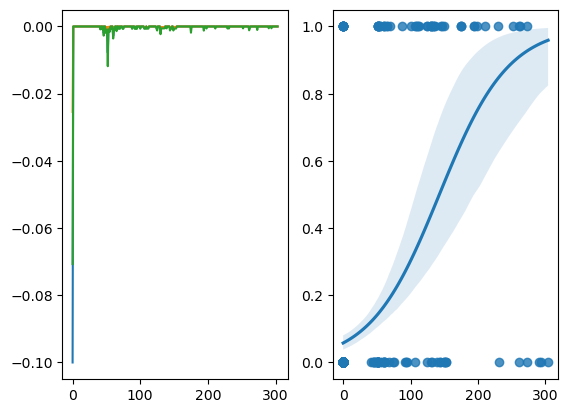

In [51]:
#Example that runs but looks weird (but still get an error if set >1 EM iterations)
pop="eas"
snp="rs17843625_G(/A)"
datasets, snps=read_data(pop)
data=datasets[snps.index(snp)]
s=run_analysis(data, alpha=1e4, beta=1e4, em_iterations=1)
fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].plot(s[:, 0], color="tab:blue", alpha=1)
axs[0].plot(s[:, 1], color="tab:orange", alpha=1)
axs[0].plot(s[:, 2], color="tab:green", alpha=1)
a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
sns.regplot(x=a, y=b, logistic=True, ax=axs[1])